# Indirect Reconstruction with Two Step approach
This notebook takes the POD modes and the corresponding coefficients to reconstruct the unobservable fields from measurements of a simple one (Temperature).

A two-step approach is used:
- First, estimate the characteristic parameter using an optimization algorithm.
- Then, reconstruct the unobservable fields using the estimated POD coefficients inferred from the parameter.

Let us create the mesh from the OpenFOAM nodes and cells.

In [1]:
import sys
path_chap3 = '../../Chapter3/BoundarySensing/'
sys.path.append(path_chap3)

from pyforce.tools.write_read import ReadFromOF
from utils import create_mesh_dolfinx
from IPython.display import clear_output as clc

path_snaps = '../../../Data/MSFR/'
domain, ct, ft, gdim = create_mesh_dolfinx(path_snaps+'EVOL_geom_noreflector.geo')

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/ufl/__init__.py:244: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Info    : Reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'...
Info    : Done reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 90%] Meshing cu

Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load(path_chap3+'Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load(path_chap3+'Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, VectorElement("Lagrange", domain.ufl_cell(), 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load(path_chap3+'Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train, test and predict
\begin{equation}
    \left\{
        \begin{aligned}
            \Xi_{\text{train}} &= [0:0.025:20] \setminus[0.1:0.1:20] \\
            \Xi_{\text{test}} &= [0.1:0.1:20]\\
            \Xi_{\text{predict}} &= [20:0.025:25]\\
        \end{aligned}
    \right.
\end{equation}
such that $\Xi_{\text{train}}\cap \Xi_{\text{test}}=\emptyset$.

This two-step approach cannot be used for predict snapshots, because is it outside the training domain.

In [3]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)
cut_train = int(0.8*Nt)

measured_field_i = 0
train_indices = np.arange(0, cut_train)
test_indices = train_indices[3::4]
train_indices = np.delete(train_indices, test_indices)

test_snaps = dict()
for field_i, field in enumerate(var_names):
    if field_i != measured_field_i:
        test_snaps[field] = FunctionsList(fun_spaces[field_i])
        for ii in test_indices:
            test_snaps[field].append(snaps[field](ii))

## Building the maps

Now, we need to load the training POD coefficients to build suitable maps
$$
\boldsymbol{\mu}\rightarrow \mathcal{F}_\alpha(\boldsymbol{\mu})
$$

In [4]:
path_offline = 'Results/POD_offline/'
alpha_coeffs = dict()
for field_i, field in enumerate(var_names):
    if field_i != measured_field_i:
        alpha_coeffs[field] = np.load(path_offline+f'POD_{field}_TrainCoeffs.npz')['arr_0']

Let us use linear interpolants and RBF interpolants to build the maps for the POD coefficients.

In [5]:
from scipy.interpolate import interp1d

pod_maps = dict()

for field_i, field in enumerate(var_names):
    if field_i != measured_field_i:
        pod_maps[field] = dict()
        
        # Build the interpolator - Linear
        pod_maps[field]['linear'] = list()
        for rr in range(alpha_coeffs[field].shape[1]):
            pod_maps[field]['linear'].append(interp1d(fom_times[train_indices], alpha_coeffs[field][:,rr], kind='linear', fill_value='extrapolate'))
            
        # Build the interpolator - Cubic
        pod_maps[field]['cubic'] = list()
        for rr in range(alpha_coeffs[field].shape[1]):
            pod_maps[field]['cubic'].append(interp1d(fom_times[train_indices], alpha_coeffs[field][:,rr], kind='linear', fill_value='extrapolate'))

Let us plot the maps for the POD coefficients

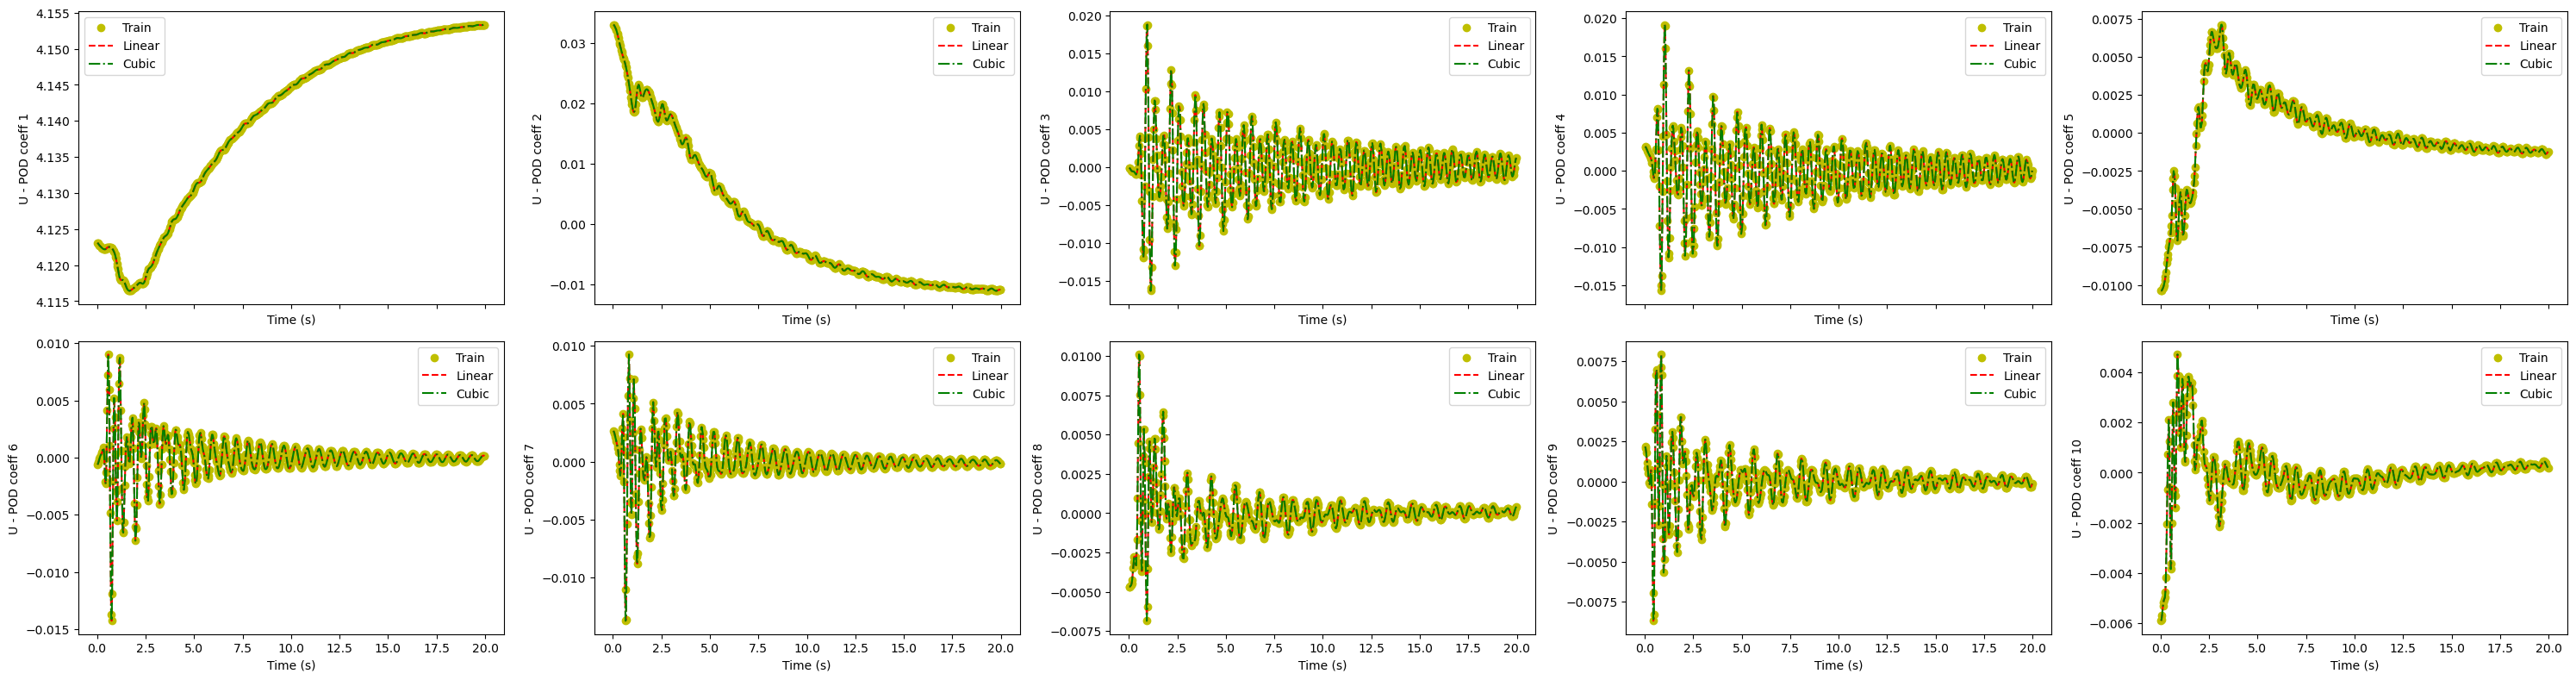

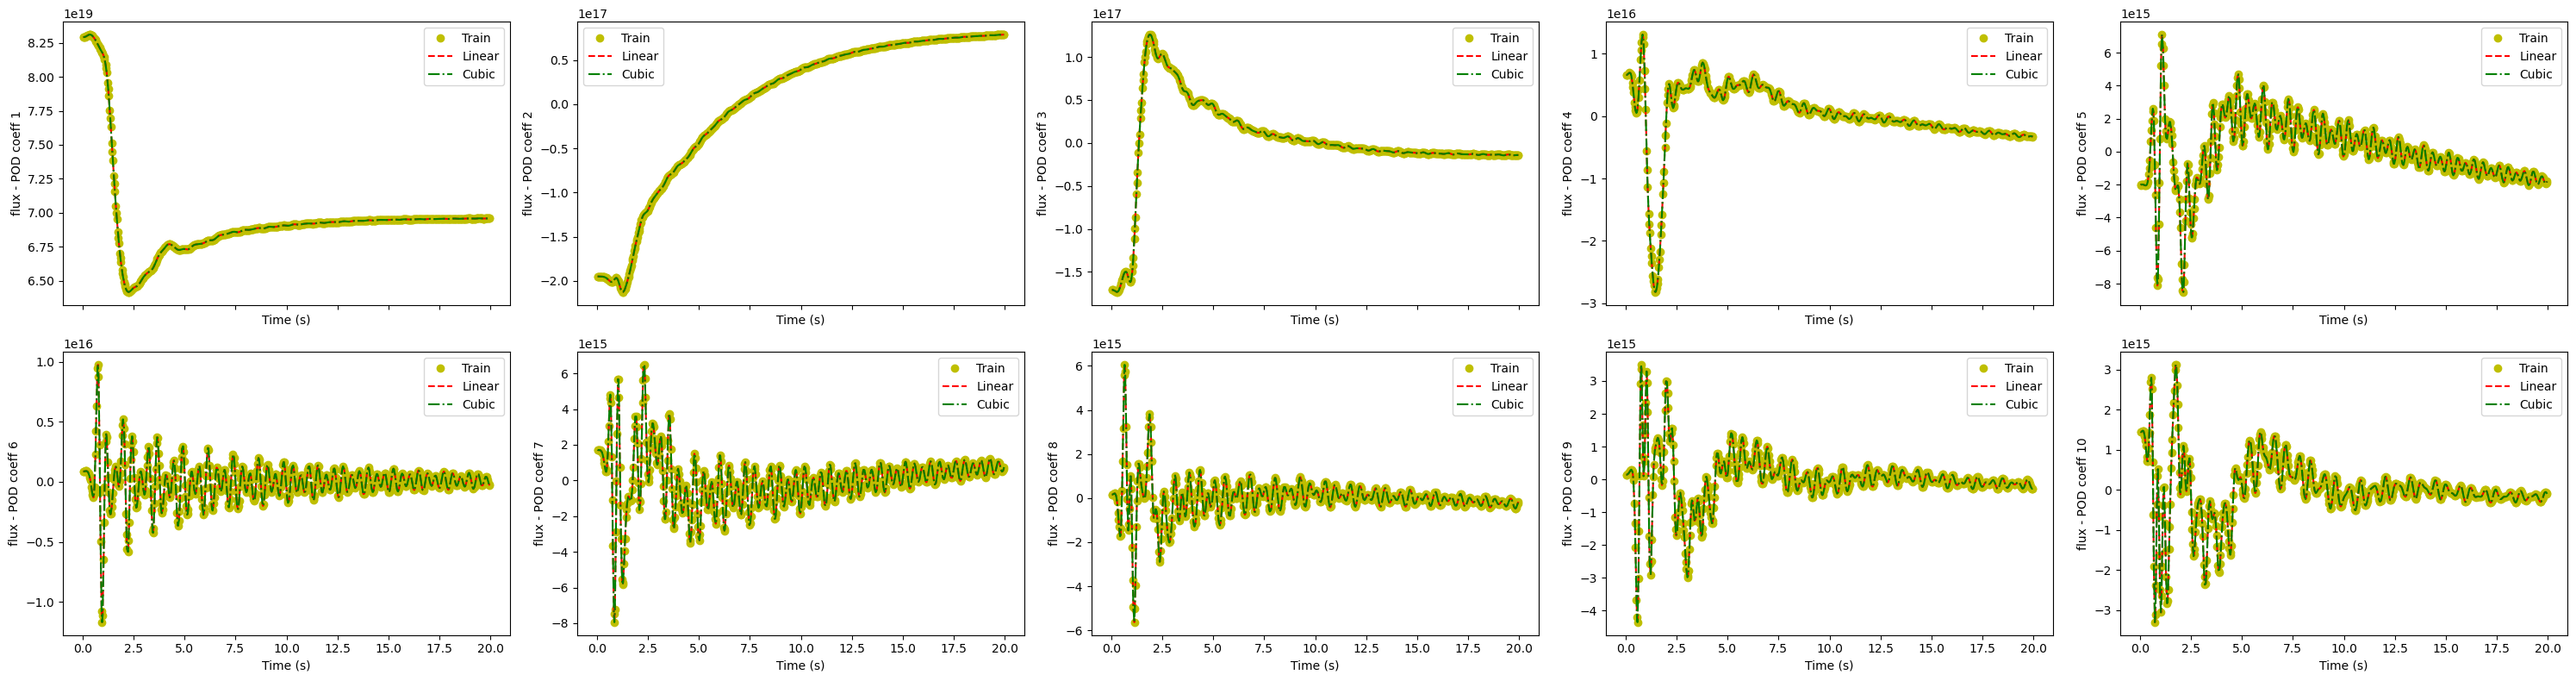

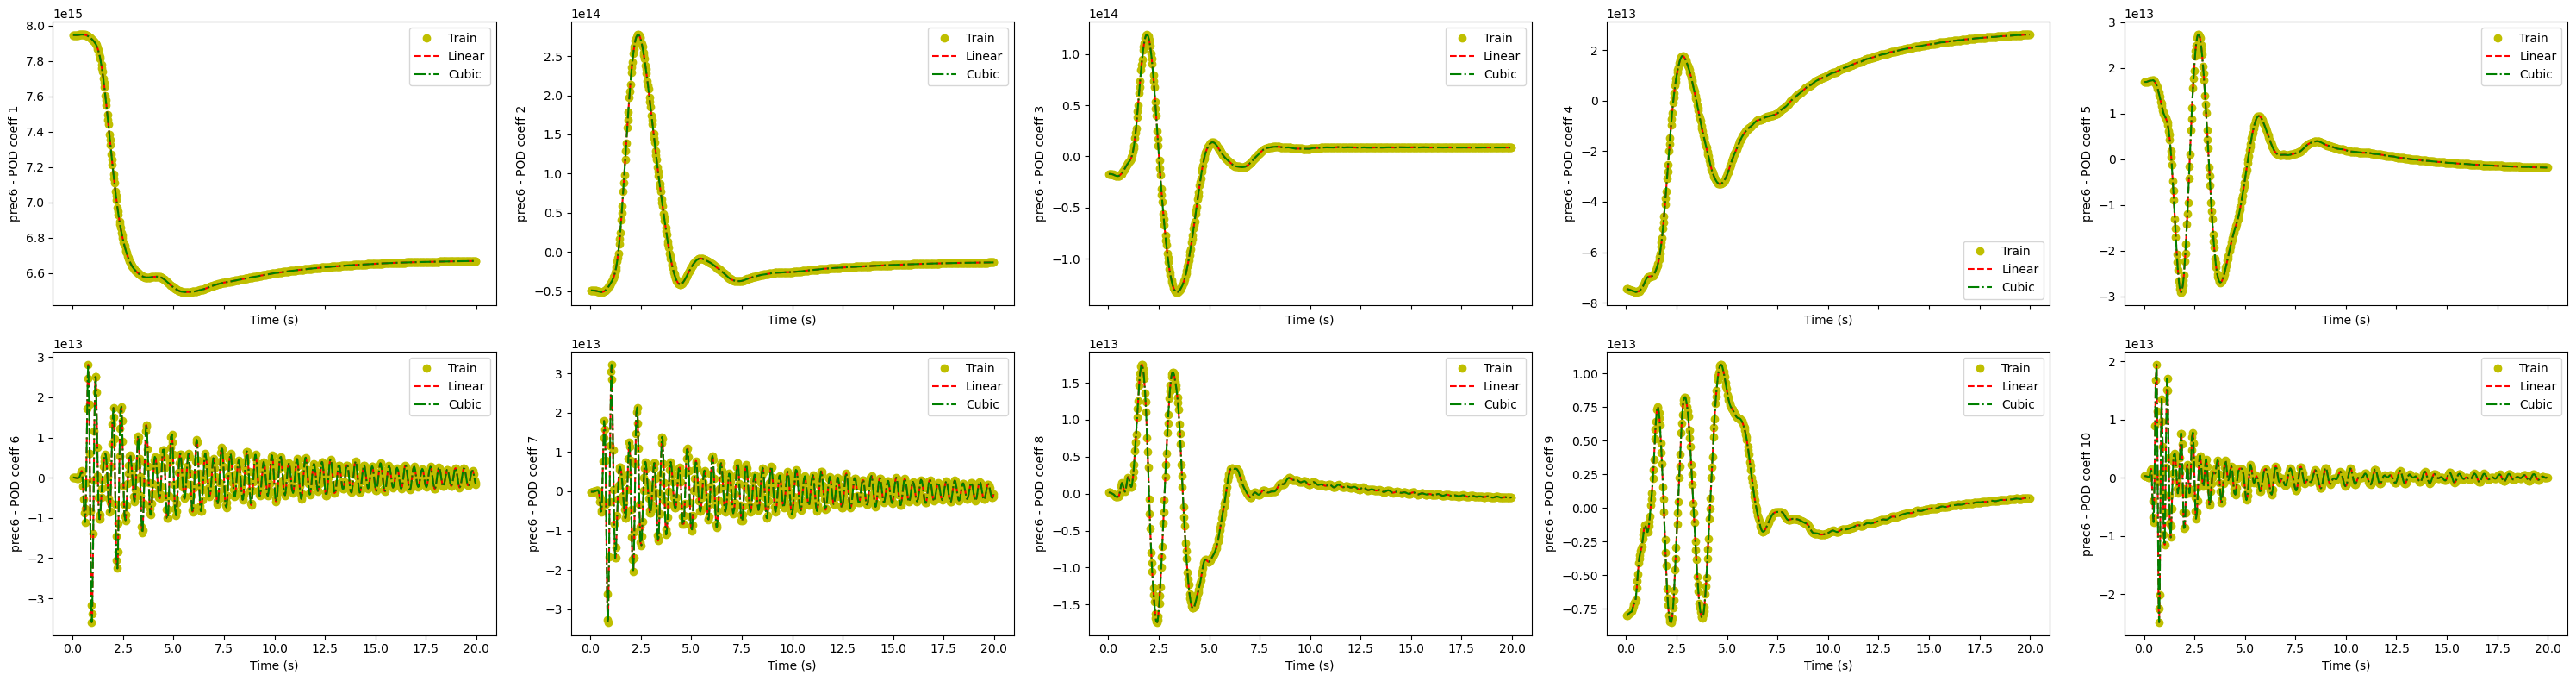

In [6]:
from matplotlib import pyplot as plt, cm

for field_i, field in enumerate(var_names):
    if field_i != measured_field_i:
        fig, axs = plt.subplots(2,5, sharex=True, figsize=(6 * 5, 4 * 2))
        axs = axs.flatten()

        for rr in range(len(axs)):
            axs[rr].plot(fom_times[train_indices], alpha_coeffs[field][:,rr], 'yo', label='Train')
            axs[rr].plot(fom_times[train_indices], pod_maps[field]['linear'][rr](fom_times[train_indices]), 'r--', label='Linear')
            axs[rr].plot(fom_times[train_indices], pod_maps[field]['cubic'][rr](fom_times[train_indices].reshape(-1,1)), 'g-.', label='Cubic')
            axs[rr].set_ylabel(f'{field} - POD coeff {rr+1}')
            axs[rr].set_xlabel('Time (s)')
            axs[rr].legend()
            
        plt.tight_layout()
        plt.show()
       

Let us also build the maps for the GEIM coefficients of the observable field

In [7]:
from scipy.interpolate import CubicSpline

strategies = ['ID', 'BF', 'BP']

Mmax = 20

beta_coeffs = {strategy: np.load(path_chap3+f'Results/GEIM_offline/GEIM_{var_names[measured_field_i]}_{strategy}_TrainBeta.npz')['arr_0'] for strategy in strategies}

geim_maps = dict()
for strategy in strategies:
    geim_maps[strategy] = dict()
    
    # Build the interpolator - Linear
    geim_maps[strategy]['linear'] = list()
    for rr in range(Mmax):
        geim_maps[strategy]['linear'].append(interp1d(fom_times[train_indices], beta_coeffs[strategy][:,rr], kind='linear', fill_value='extrapolate'))

    # Build the interpolator - Cubic
    geim_maps[strategy]['cubic'] = list()
    for rr in range(Mmax):
        geim_maps[strategy]['cubic'].append(CubicSpline(fom_times[train_indices], beta_coeffs[strategy][:,rr], extrapolate=True))

Let us plot the maps for the GEIM coefficients

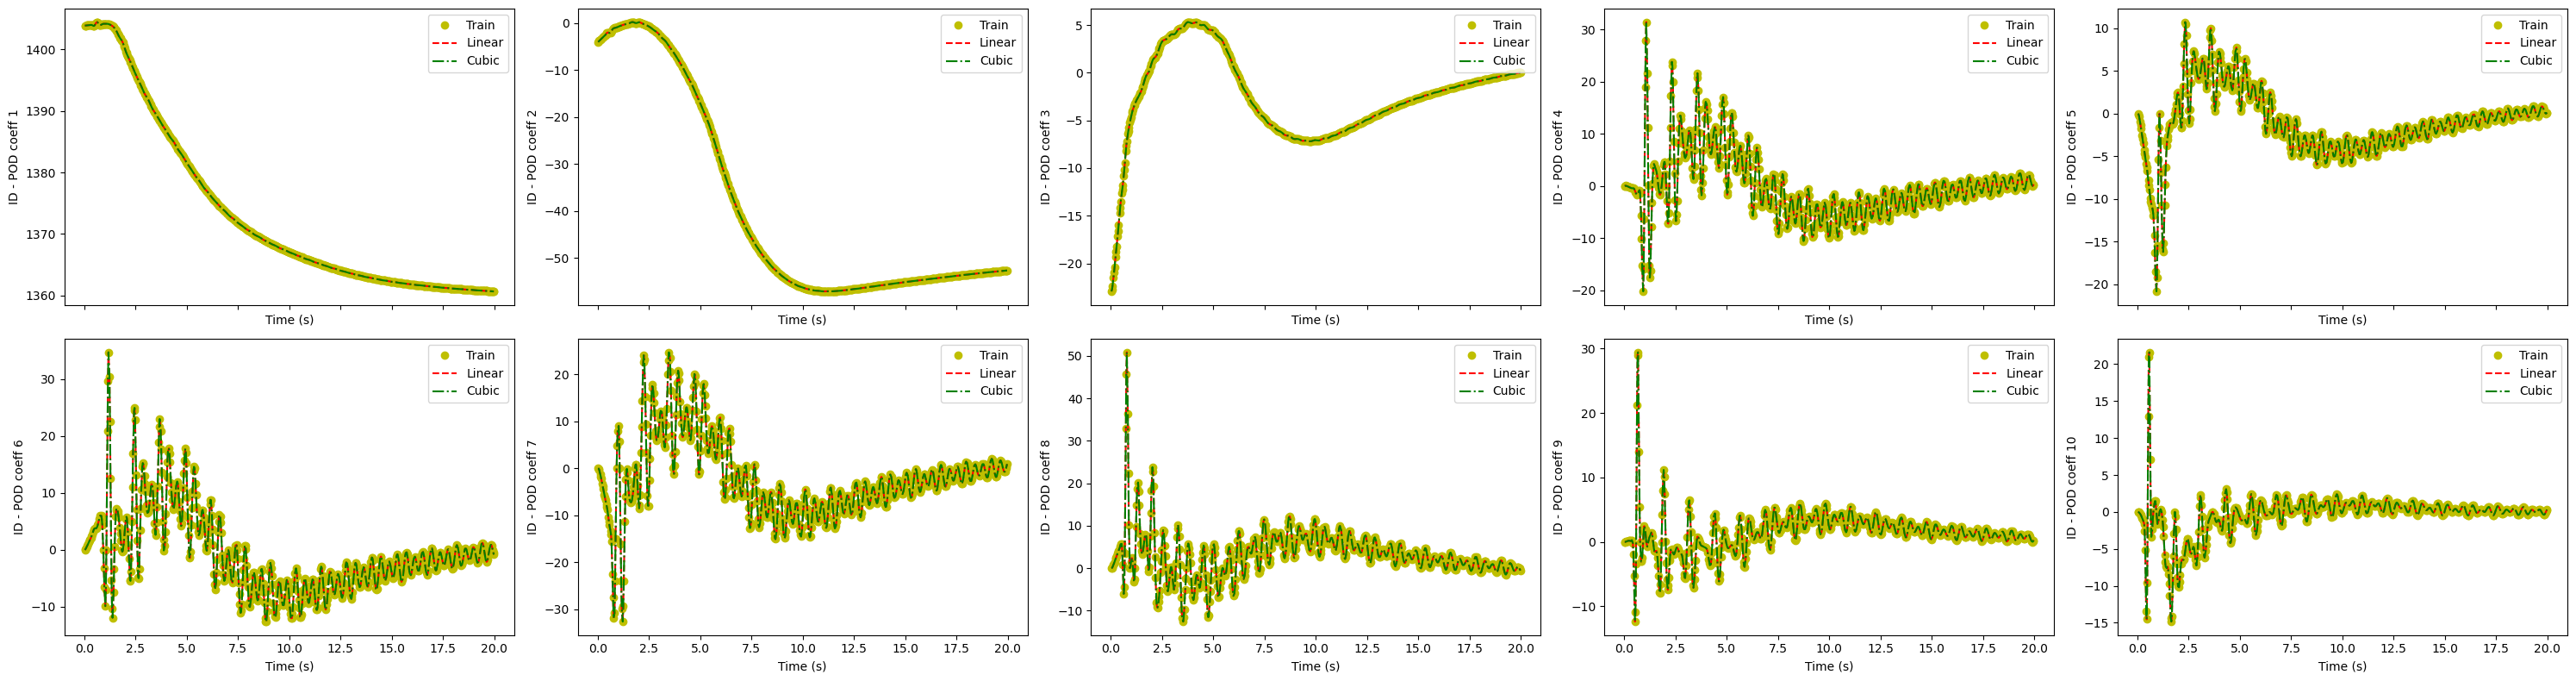

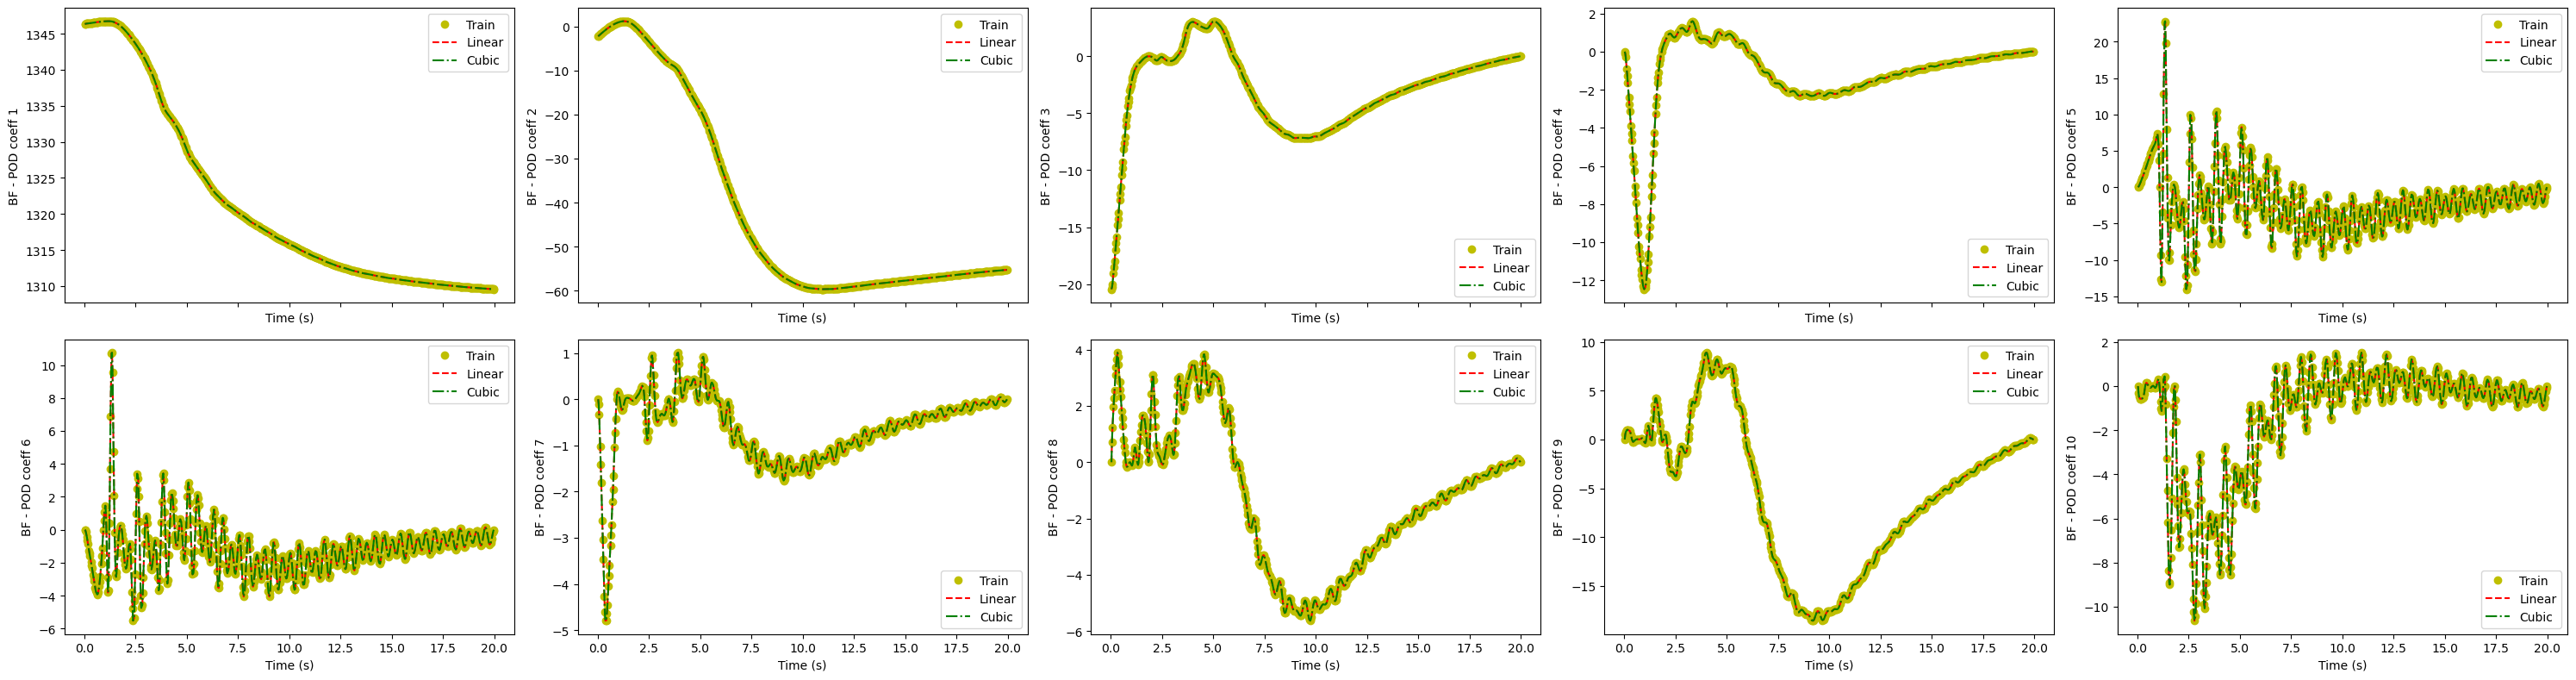

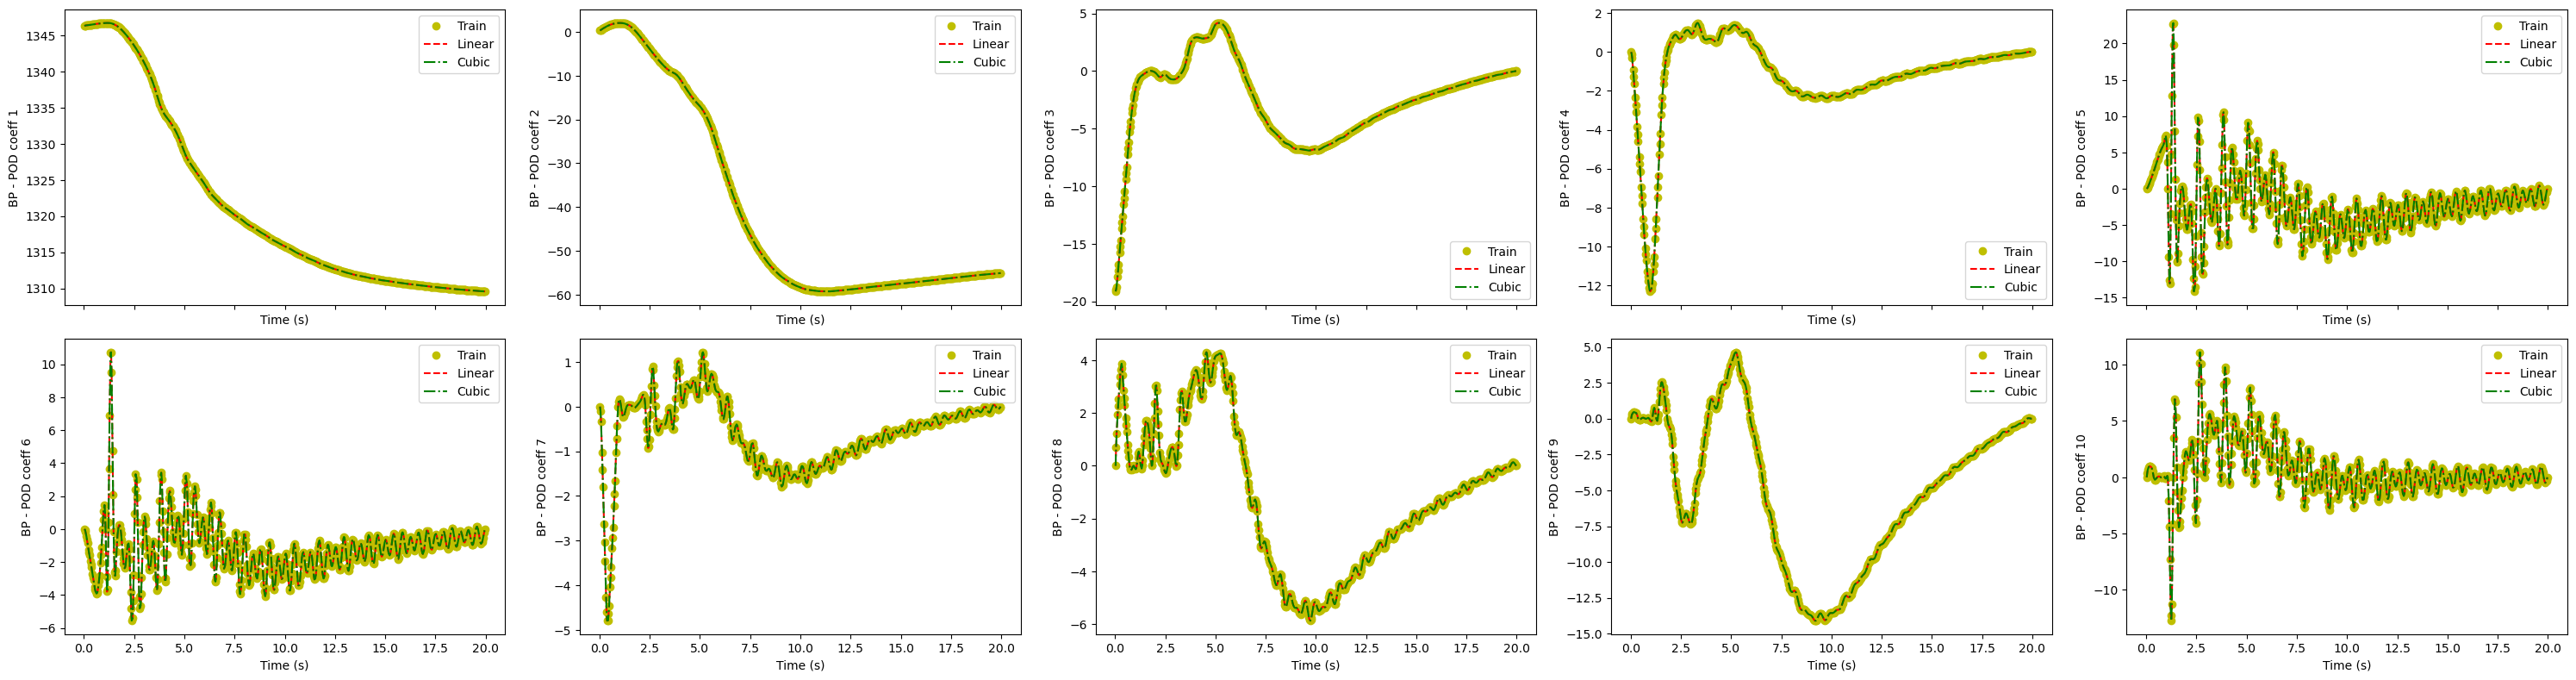

In [8]:
from matplotlib import pyplot as plt, cm

for str_i, strategy in enumerate(strategies):
    fig, axs = plt.subplots(2,5, sharex=True, figsize=(6 * 5, 4 * 2))
    axs = axs.flatten()

    for rr in range(len(axs)):
        axs[rr].plot(fom_times[train_indices], beta_coeffs[strategy][:,rr], 'yo', label='Train')
        axs[rr].plot(fom_times[train_indices], geim_maps[strategy]['linear'][rr](fom_times[train_indices]), 'r--', label='Linear')
        axs[rr].plot(fom_times[train_indices], geim_maps[strategy]['cubic'][rr](fom_times[train_indices].reshape(-1,1)), 'g-.', label='Cubic')
        axs[rr].set_ylabel(f'{strategy} - POD coeff {rr+1}')
        axs[rr].set_xlabel('Time (s)')
        axs[rr].legend()
        
    plt.tight_layout()
    plt.show()
       

## Parameter Estimation
Now, we need to estimate the characteristic parameter using the optimization algorithm.

We need to import the magic functions and sensors to extract the measures and the GEIM matrix.

In [9]:
from pyforce.tools.write_read import ImportH5

magic_functions = {strategy: ImportH5(fun_spaces[measured_field_i],
                          path_chap3+f'Results/GEIM_offline/GEIM_{var_names[measured_field_i]}_{strategy}_mf',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_mf')[0]
                for strategy in strategies}
magic_sensors = {strategy: ImportH5(fun_spaces[measured_field_i],
                          path_chap3+f'Results/GEIM_offline/GEIM_{var_names[measured_field_i]}_{strategy}_ms',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_ms')[0]
                for strategy in strategies}

Let us import the observable field

In [10]:
obs_field = FunctionsList(fun_spaces[measured_field_i])
for ii in test_indices:
    obs_field.append(snaps[var_names[measured_field_i]](ii))

Let us build the matrix $B$, defined as $B_{ij} = v_i(q_j)$, where $v_i$ is the $i$-th magic sensors and $q_j$ is the $j$-th magic function.

In [11]:
from pyforce.tools.backends import norms

_norm = norms(fun_spaces[measured_field_i])

matrix_B = {strategy: np.zeros((Mmax, Mmax)) for strategy in strategies}
for strategy in strategies:
    for rr in range(Mmax):
        for ss in range(Mmax):
            matrix_B[strategy][rr, ss] = _norm.L2innerProd(magic_functions[strategy](ss), magic_sensors[strategy](rr))

Let us estimate the characteristic parameter using the optimization algorithm.

In [12]:
from pyforce.online.indirect_recon import PE

bnds = [(0.025, 20.)]
test_parameters = fom_times[test_indices].reshape(-1, 1)

In [13]:
pe_online = dict()
pe_comp_time = dict()
mu_estimated = dict()

for strategy in strategies:

    print(f'Running online PE for strategy: {strategy}')
    pe_online[strategy] = PE(matrix_B[strategy], geim_maps[strategy]['linear'], bnds)

    res = pe_online[strategy].synt_test_error(test_parameters, obs_field, magic_sensors[strategy], Mmax, 
                                    noise_value=0.5, verbose=True, use_brute=False)
    
    # Store results
    pe_comp_time[strategy] = res[2]
    mu_estimated[strategy] = np.asarray(res[3])

Running online PE for strategy: ID
Solving Parameter Estimation : 200.000 / 200.00 - 0.507 s/it
Running online PE for strategy: BF
Solving Parameter Estimation : 200.000 / 200.00 - 0.459 s/it
Running online PE for strategy: BP
Solving Parameter Estimation : 200.000 / 200.00 - 0.454 s/it


Let us plot the results using a QQ plot

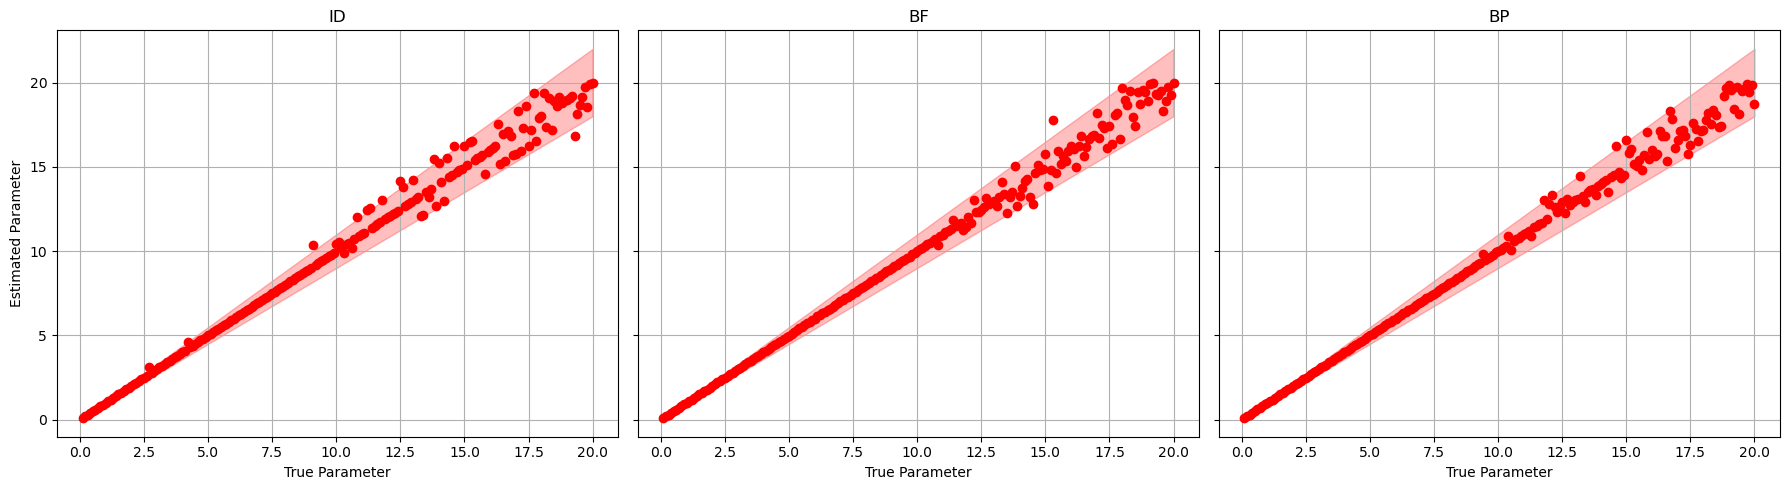

In [14]:
fig, axs = plt.subplots(1, len(strategies), figsize=(6 * len(strategies), 5), sharex=True, sharey=True)

for str_i, strategy in enumerate(strategies):
    axs[str_i].plot(fom_times[test_indices], mu_estimated[strategy][:, 15, 0], 'ro')
    axs[str_i].fill_between(fom_times[test_indices], 
                            fom_times[test_indices]*0.9,
                            fom_times[test_indices]*1.1,
                            color='red', alpha=0.25)
    axs[str_i].set_xlabel('True Parameter')
    axs[str_i].set_title(f'{strategy}')
    axs[str_i].grid()

axs[0].set_ylabel('Estimated Parameter')
plt.tight_layout()

## POD with Interpolation
Now, we can reconstruct the unobservable fields using the estimated POD coefficients inferred from the parameter.

Let us load the POD modes at First

In [15]:
pod_modes = dict()

for field_i, field in enumerate(var_names):
    if field_i != measured_field_i:
        pod_modes[field] = ImportH5(fun_spaces[field_i],
                                    path_offline+f'POD_{field}_modes',
                                    f'POD_{field}_modes')[0]

Let us initialize the class for POD with Interpolation

In [16]:
from pyforce.online.pod_interpolation import PODI

podi_online = dict()
for strategy in strategies:
    podi_online[strategy] = dict()
    for field_i, field in enumerate(var_names):
        if field_i != measured_field_i:
            podi_online[strategy][field] = PODI(pod_modes[field], pod_maps[field]['linear'], field)

Let us compute the synthetic test error

In [17]:
mean_abs_err = dict()
mean_rel_err = dict()
podi_compt_time = dict()

for strategy in strategies:
    mean_abs_err[strategy] = dict()
    mean_rel_err[strategy] = dict()
    podi_compt_time[strategy] = dict()

    mu_star = mu_estimated[strategy][:, Mmax-1, :]

    for field_i, field in enumerate(var_names):
        if field_i != measured_field_i:

            print(f'Running PODI for strategy: {strategy}, field: {field}')

            res = podi_online[strategy][field].synt_test_error(test_snaps[field], mu_star, len(pod_modes[field]), verbose=False)

            mean_abs_err[strategy][field] = res[0]
            mean_rel_err[strategy][field] = res[1]
            podi_compt_time[strategy][field] = res[2]

Running PODI for strategy: ID, field: U
Running PODI for strategy: ID, field: flux
Running PODI for strategy: ID, field: prec6
Running PODI for strategy: BF, field: U
Running PODI for strategy: BF, field: flux
Running PODI for strategy: BF, field: prec6
Running PODI for strategy: BP, field: U
Running PODI for strategy: BP, field: flux
Running PODI for strategy: BP, field: prec6


Let us plot the errors

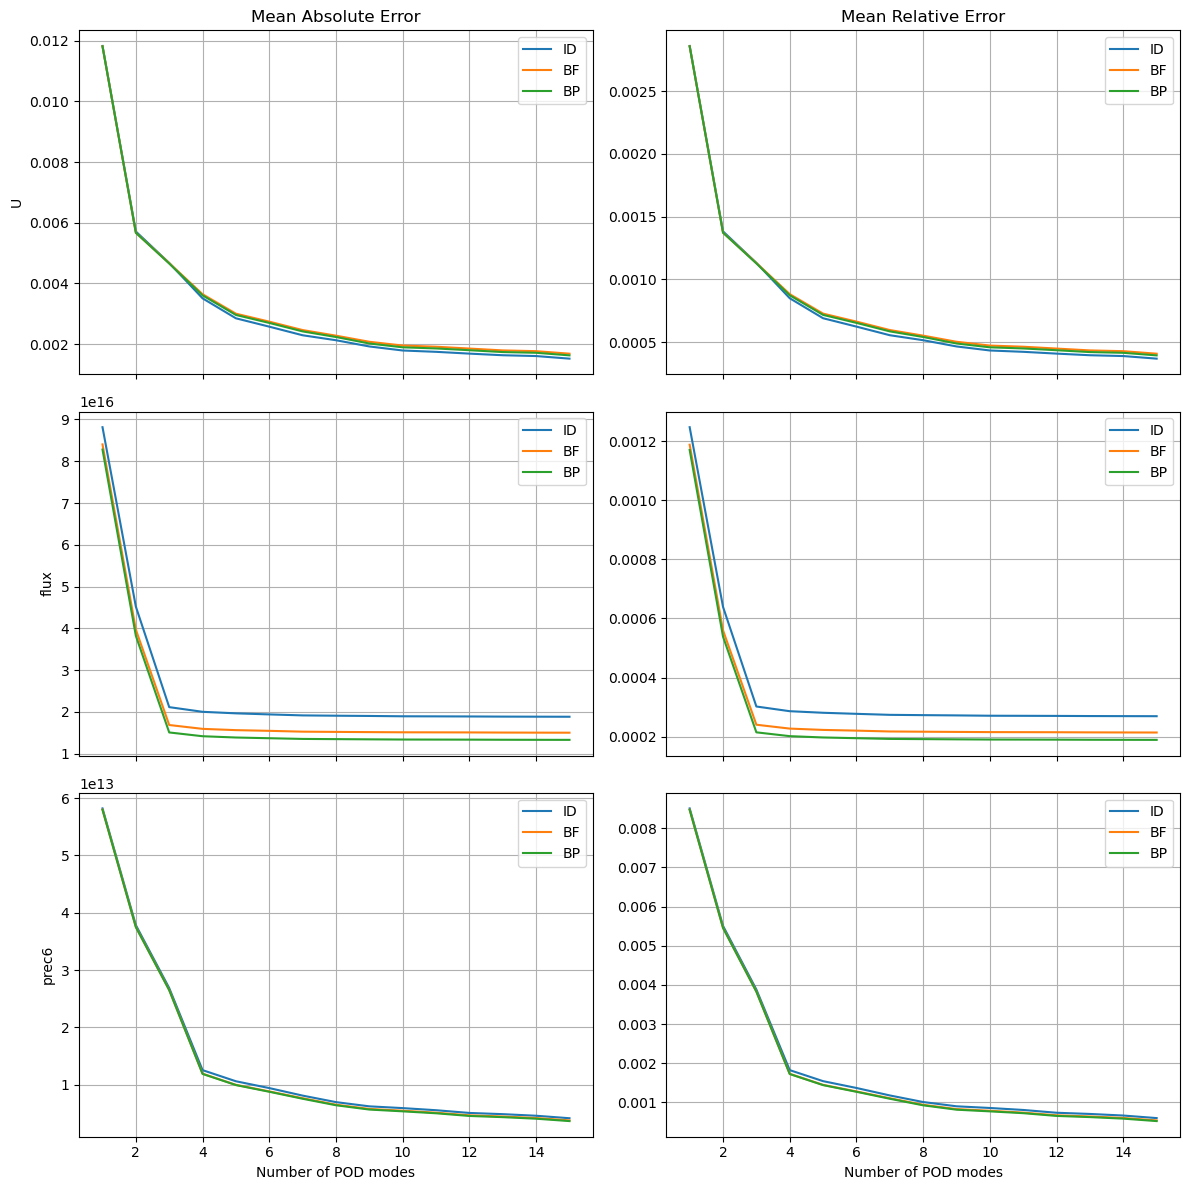

In [18]:
fig, axs = plt.subplots(len(var_names)-1, 2, figsize=(12, 4 * (len(var_names)-1)), sharex=True)

Nplot = np.arange(1, len(pod_modes[field])+1)

for field_i, field in enumerate(var_names):
    if field_i != measured_field_i:
        for str_i, strategy in enumerate(strategies):
                axs[field_i-1, 0].plot(Nplot, mean_abs_err[strategy][field], label=strategy)
                axs[field_i-1, 1].plot(Nplot, mean_rel_err[strategy][field], label=strategy)

        axs[field_i-1, 0].set_ylabel(f'{field}')
        axs[field_i-1, 0].legend()
        axs[field_i-1, 1].legend()
        
axs[0, 0].set_title('Mean Absolute Error')
axs[0, 1].set_title('Mean Relative Error')
axs[-1, 0].set_xlabel('Number of POD modes')
axs[-1, 1].set_xlabel('Number of POD modes')

for ax in axs.flatten():
    ax.grid()

plt.tight_layout()

Let us plot the computational times

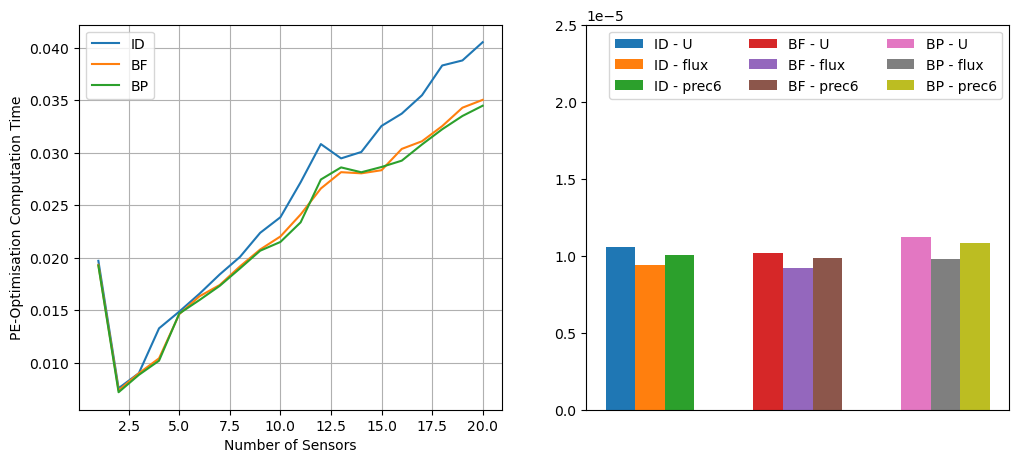

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ii, strategy in enumerate(strategies):

    # Plot the PE-Optimisation computation time
    axs[0].plot(np.arange(1, Mmax+1), pe_comp_time[strategy]['Optimisation'].mean(axis=0), label=strategy)
    axs[0].legend()
    axs[0].set_ylabel('PE-Optimisation Computation Time')
    axs[0].set_xlabel('Number of Sensors')
    axs[0].grid()

    # Plot the PODI computation time
    for field_i, field in enumerate(var_names):
        if field_i != measured_field_i:
            x_bar = (ii+1) + 0.2 * (field_i-1)
            
            axs[1].bar(x_bar, podi_compt_time[strategy][field]['CoeffEstimation'].mean(), width=0.2, label=f'{strategy} - {field}')
            axs[1].legend(ncols=3)
            axs[1].set_xticks([])
            axs[1].set_ylim(0, 2.5e-5)

Let us make a plot of the reconstructed fields

In [58]:
from utils import plot_contour

mesh_plot = np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 1]]).T

field = 'prec6'
vec_mode_to_plot = True if field == 'U' else None
streamline_plot = True if field == 'U' else False
levels = np.linspace(0, 4, 50) if field == 'U' else np.linspace(test_snaps[field].return_matrix().min(), test_snaps[field].return_matrix().max(), 50)

if field == 'U':
    cmap= cm.RdYlBu_r
elif field == 'flux':
    cmap = cm.seismic
elif field == 'prec6':
    cmap = cm.magma

sampling = 10

import os
path_figs = f'Results/OnlineReconstruction/{field}/'
os.makedirs(path_figs, exist_ok=True)

save_gif = True

for tt in range(sampling-1, len(fom_times[test_indices]), sampling):
    fig, axs = plt.subplots(2, len(strategies)+1, figsize=(6 * (len(strategies)+1), 6 * 2))

    cont = plot_contour(axs[0,0], mesh_plot, test_snaps[field](tt), levels=levels, vec_mode_to_plot=vec_mode_to_plot, cmap=cmap, streamline_plot = streamline_plot)
    axs[0,0].set_title(f'FOM', fontsize=20)

    axs[1,0].axis('off')
    cbar = fig.colorbar(cont, ax=axs[1,0], orientation='horizontal')
    cbar.ax.set_position([-0.18, 0.3, 0.8, 0.02])
    cbar.ax.set_xticks(np.linspace(levels.min(), levels.max(), 5))
    cbar.ax.tick_params(labelsize=12)

    for ii, strategy in enumerate(strategies):
        rec = podi_online[strategy][field].reconstruct(test_snaps[field](tt), mu_estimated=mu_star[tt].reshape(-1,1), maxBasis=len(pod_modes[field]))[0]
        plot_contour(axs[0, ii+1], mesh_plot, rec, levels=levels, vec_mode_to_plot=vec_mode_to_plot, cmap=cmap, streamline_plot = streamline_plot)
        axs[0, ii+1].set_title(f'{strategy} - PODI', fontsize=20)

        residual = np.abs(test_snaps[field](tt) - rec)
        res_cont = plot_contour(axs[1, ii+1], mesh_plot, residual, levels=20, vec_mode_to_plot=vec_mode_to_plot, cmap='viridis')
        fig.colorbar(res_cont, ax=axs[1, ii+1], orientation='vertical', fraction=0.046, pad=0.04)

    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="wheat", alpha=0.5)
    fig.text(0.225, 0.4, f'PODI reconstruction at t = {fom_times[test_indices[tt]]:.2f} s', 
             ha='center', va='top', fontsize=16, bbox=bbox_props)
    
    if save_gif:
        fig.savefig(f'{path_figs}BoundarySensing_{field}_{tt+1:04d}.png', bbox_inches='tight', dpi=100)
    else:
        plt.show()
        clc(wait=True)
    plt.close(fig)

Let us create a gif of the contour plots.

In [59]:
import imageio.v2 as imageio

# Create the GIF by loading each image and adding it to the array
def create_gif(gif_path, path_imgs, image_files, duration=150.):
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for img_file in image_files:
            img_path = os.path.join(path_imgs, img_file)
            image = imageio.imread(img_path)
            writer.append_data(image)

if save_gif:

    image_files = sorted(os.listdir(path_figs), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    path_gif = 'Media/'
    os.makedirs(path_gif, exist_ok=True)
    create_gif(path_gif+f'OnlineReconstruction_{field}.gif', path_figs, image_files, duration=150.)